<h1> Dimensional reduction and clustering </h1>

In [27]:
library(SingleCellExperiment)

In [28]:
# Load Ernest TF data


load("data/ernst/spermatogenesisAllCellsErnstTF.Rdata")
sce_TF


class: SingleCellExperiment 
dim: 1505 18345 
metadata(0):
assays(2): counts logcounts
rownames(1505): ENSMUSG00000025902 ENSMUSG00000033740 ...
  ENSMUSG00000006270 ENSMUSG00000043969
rowData names(6): ID Symbol ... ontologyTerm UNIPROT
colnames(18345): S9 - 1 S10 - 2 ... S4 - 53509 S11 - 53510
colData names(20): Sample Barcode ... kmeans_order cellType1
reducedDimNames(3): PCA UMAP TSNE
mainExpName: NULL
altExpNames(0):

In [30]:
table(sce_TF$AnnotatedClusters)


            D           eP1           eP2           lP1           lP2 
         1042           602          1175          1532          1399 
           MI           MII            mP            S1           S10 
          608           753          1333          1248           857 
          S11            S2            S3            S4            S5 
          969           879           490           793           704 
           S6            S7            S8            S9 Spermatogonia 
          890           375           385           483          1828 

eP: early-pachytene SC, mP: mid-pachytene SC, lP: late-pachytene SC, D: diplotene SC, MI: metaphase I, MII: metaphase II, RS1o2: S1–2 spermatids, RS3o4: S3–4 spermatids, RS5o6: S5-6 spermatids, RS7o8: S7-8 spermatids

In [31]:
# Find high variable genes
library(scran)
dec <- modelGeneVar(sce_TF)
hvg <- getTopHVGs(dec, prop=0.1)
head(hvg)

[1] "ENSMUSG00000048686" "ENSMUSG00000046957" "ENSMUSG00000008393"
[4] "ENSMUSG00000003923" "ENSMUSG00000027938" "ENSMUSG00000023467"

In [32]:
# Dimensionality reduction unsing PCA
library(scater)
set.seed(1234)
sce_TF <- runPCA(sce_TF, ncomponents=12, subset_row=hvg)

In [33]:

library(bluster)
colLabels(sce_TF) <- clusterCells(sce_TF, use.dimred='PCA',
                               BLUSPARAM=NNGraphParam(cluster.fun="louvain"))    

<h3>Dimensionality reduction using UMAP</h3>

In [34]:
sce_TF <- runUMAP(sce_TF, dimred = 'PCA')

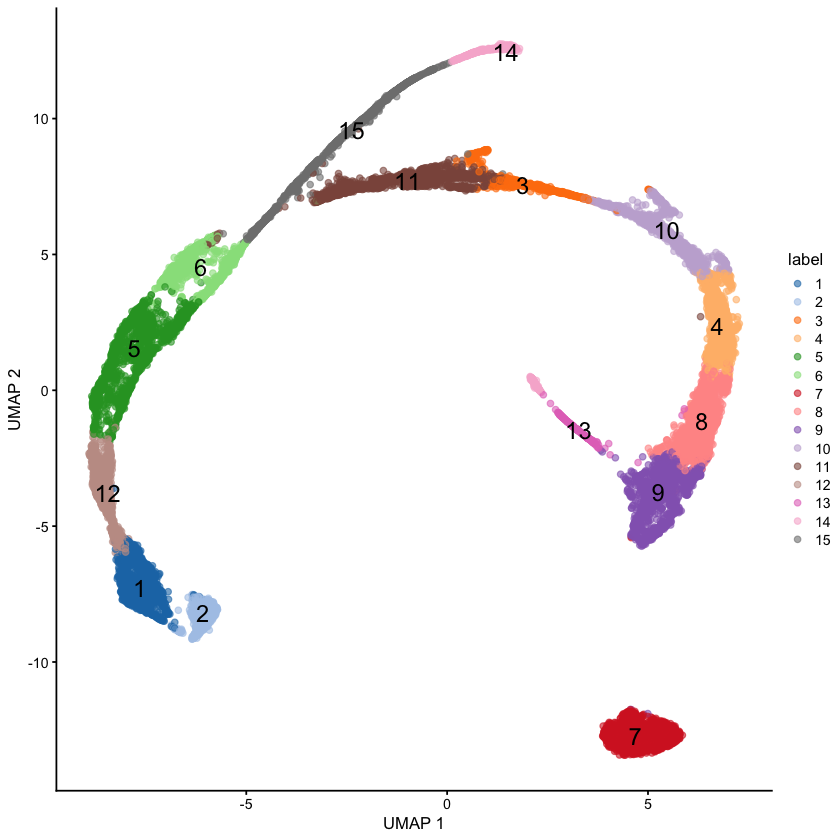

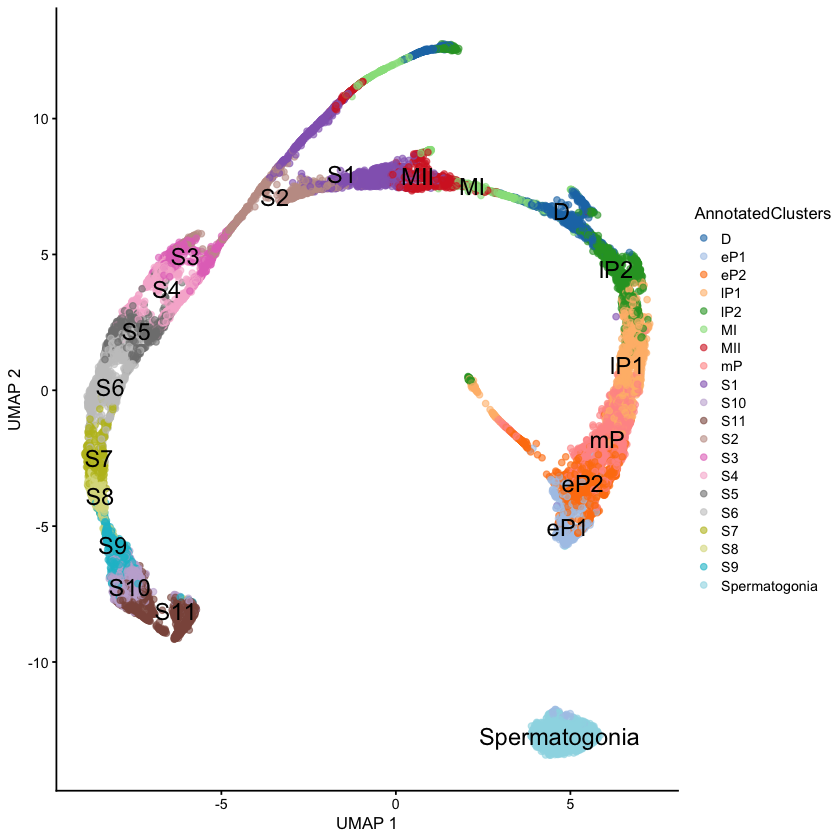

In [35]:
#Plot UMAP and label the cluster based on louvain using transcription factors

plotUMAP(sce_TF, colour_by="label", , text_by="label")

#Plot UMAP and label the cluster based on Ernes analysis using all genes
plotUMAP(sce_TF, colour_by ="AnnotatedClusters", , text_by="AnnotatedClusters")

 eP: early-pachytene SC,
mP: mid-pachytene SC, lP: late-pachytene SC, D: diplotene SC, MI: metaphase I, MII: metaphase II, RS1o2: S1–2 spermatids, RS3o4: S3–4 spermatids, RS5o6:
S5-6 spermatids, RS7o8: S7-8 spermatids

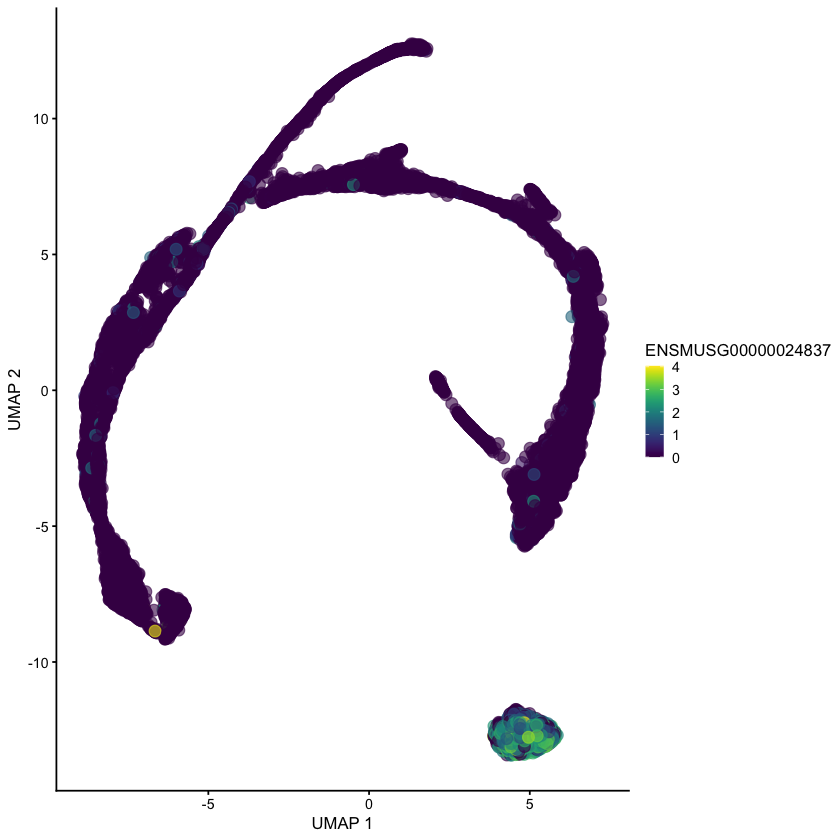

In [38]:
# Add gene expression in the UMAP plot
geneSymbol = rowData(sce_TF)[ rowData(sce_TF)[,"Symbol"]=="Dmrt1"  ,"ID"] 
plotUMAP(sce_TF, colour_by=geneSymbol, point_size = 3)

<h3>Dimensionality reduction using t-SNE</h3>

In [39]:
sce_TF <- runTSNE(sce_TF, perplexity = 3)

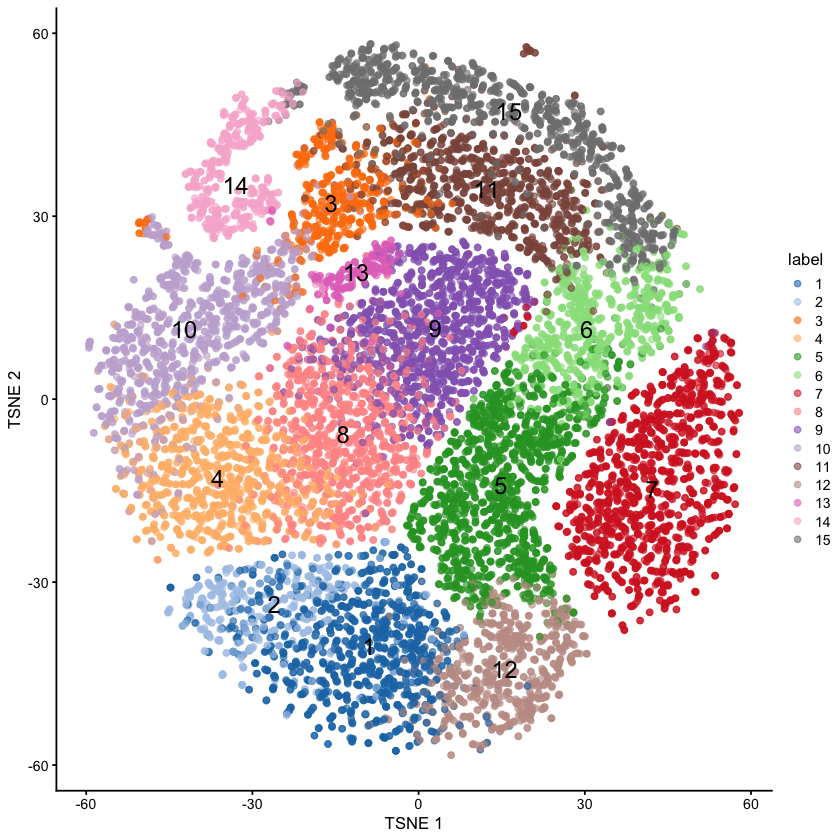

In [40]:
plotTSNE(sce_TF, colour_by = "label", text_by="label")

In [53]:
sce_TF <- runTSNE(sce_TF, perplexity = 20)


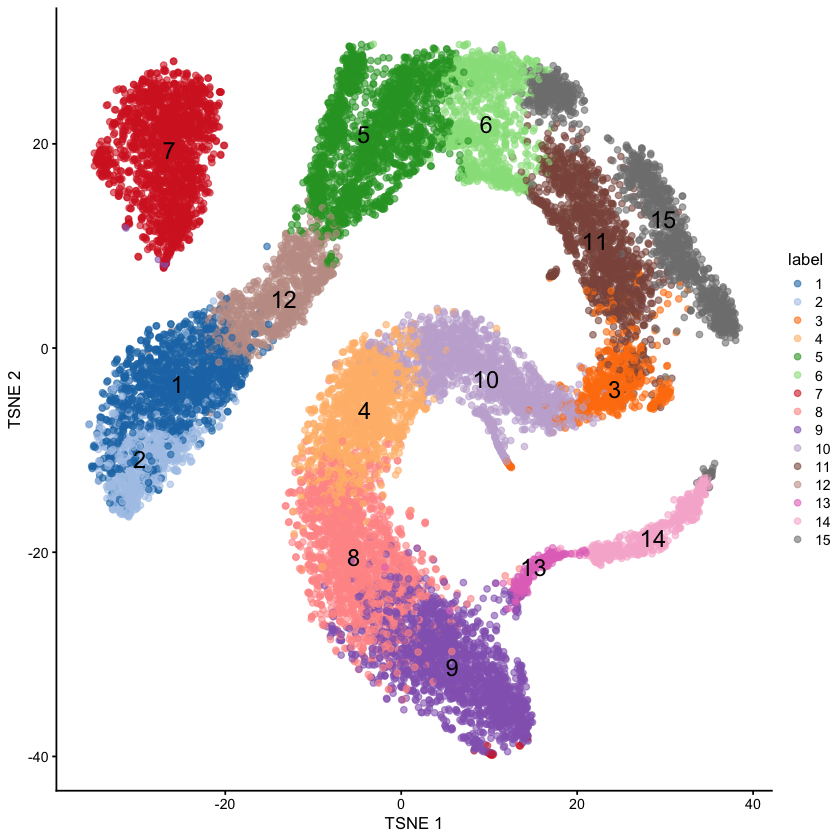

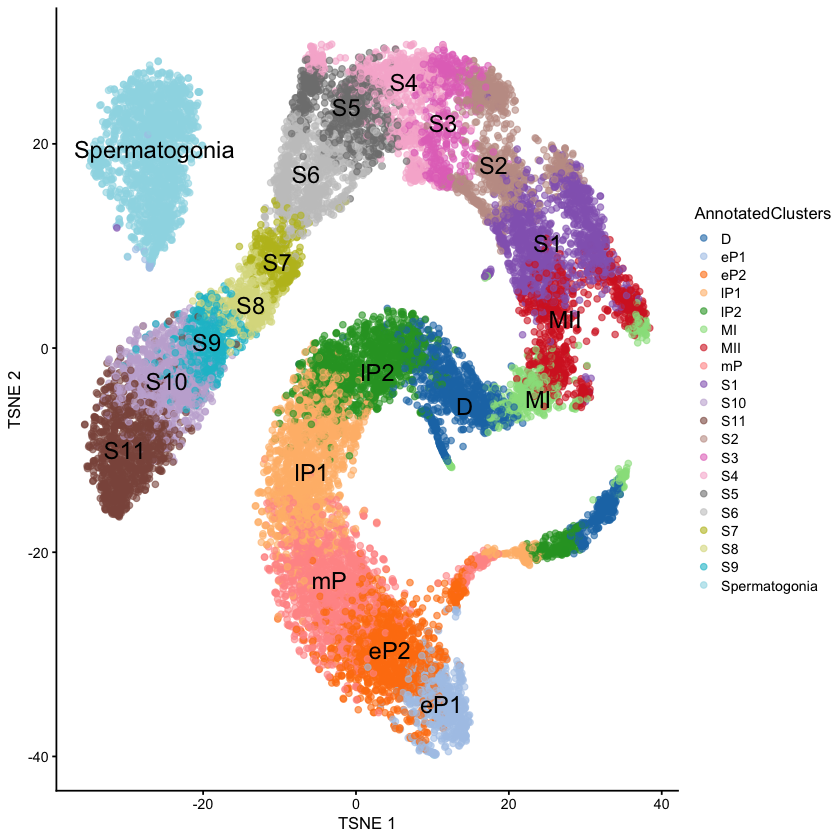

In [54]:
plotTSNE(sce_TF, colour_by = "label", text_by="label")
plotTSNE(sce_TF, colour_by = "AnnotatedClusters", text_by="AnnotatedClusters")

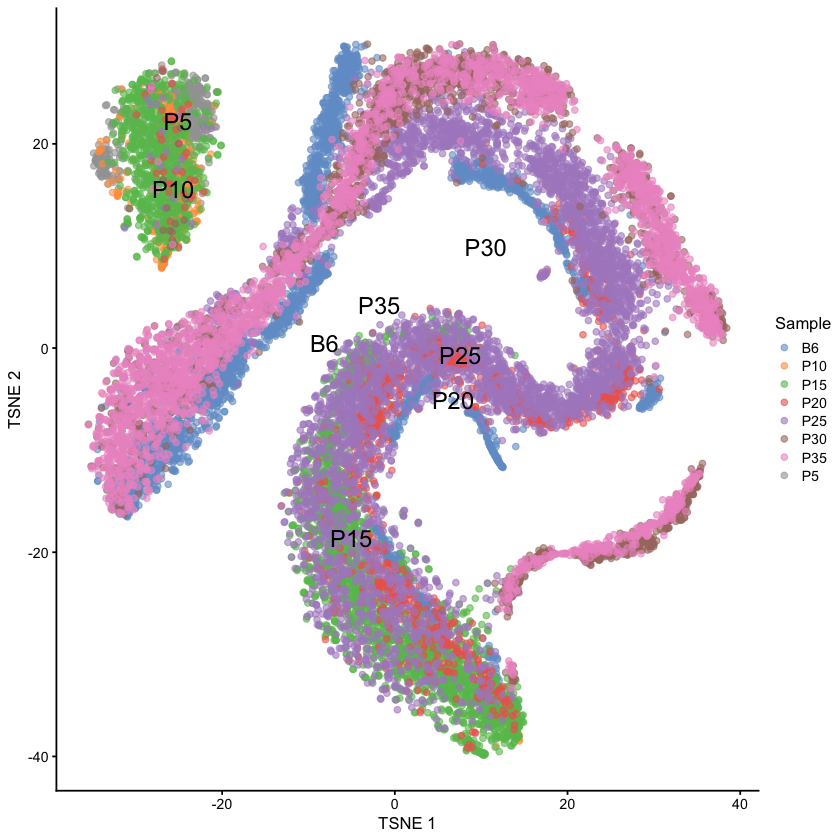

In [55]:
plotTSNE(sce_TF, colour_by = "Sample", text_by="Sample")

<h3>Clustering unisg ward.D2</h3>

In [56]:
pcs <- reducedDim(sce_TF, "PCA")
my.dist <- dist(pcs)
my.tree <- hclust(my.dist, method="ward.D2")

In [57]:
library(dynamicTreeCut)
my.clusters <- unname(cutreeDynamic(my.tree, distM=as.matrix(my.dist), 
    minClusterSize=10, verbose=0))

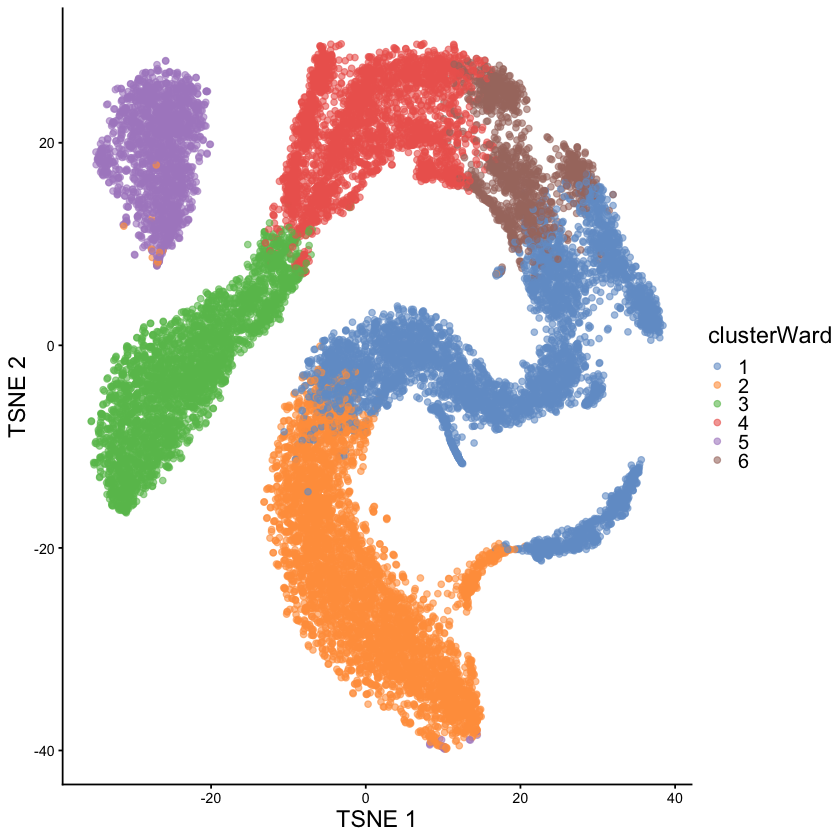

In [58]:
sce_TF$clusterWard <- factor(my.clusters)
plotTSNE(sce_TF, colour_by="clusterWard") + theme(text = element_text(size=14))

<h3>Clustering using KmeansParam</h3>

In [59]:
mat <- reducedDim(sce_TF, "PCA")

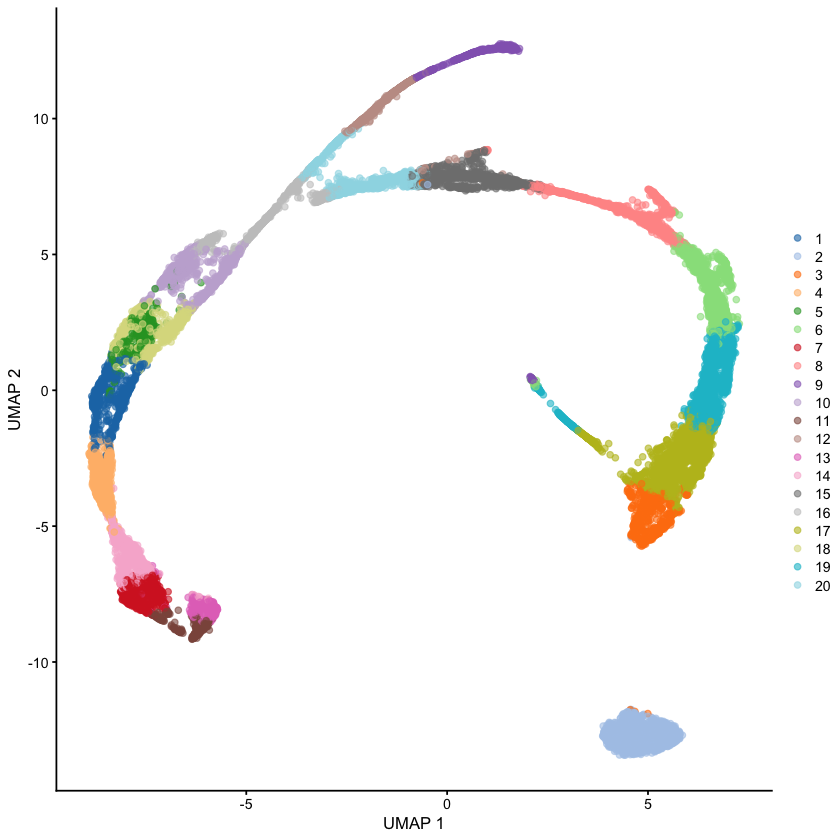

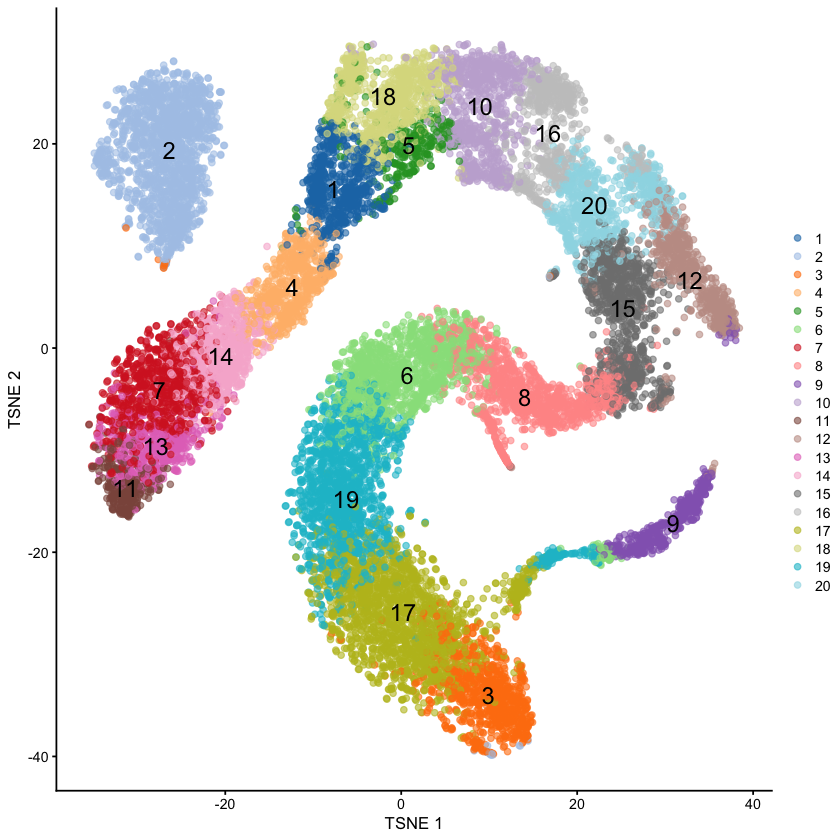

In [60]:
set.seed(100)
kmeans.out <- clusterRows(mat, KmeansParam(20))
plotUMAP(sce_TF, colour_by=I(kmeans.out))
plotTSNE(sce_TF, colour_by = I(kmeans.out), text_by=I(kmeans.out))

In [61]:
# Clustering using kmeans compared with clustering from original data
sce_TF$kmeans <- I(kmeans.out)
cell_type_table = table( sce_TF$AnnotatedClusters, sce_TF$kmeans)


In [62]:
cell_type_table

               
                   1    2    3    4    5    6    7    8    9   10   11   12
  D                0    0    0    0    0   44    0  754  244    0    0    0
  eP1              0   25  555    0    0    0    0    0    0    0    0    0
  eP2              0    0  323    0    0    0    0    0    0    0    0    0
  lP1              0    0    0    0    0  281    0    0    4    0    0    0
  lP2              0    0    0    0    0 1071    0  115  180    0    0    0
  MI               0    0    0    0    0    1    0  316   76    0    0  100
  MII              0    0    0    0    0    0    0   25    0    0    0  249
  mP               0    0    5    0    0    0    0    0    0    0    0    0
  S1               0    1    2    0    0    1    0    0    0    0    0  316
  S10              0    0    0    1    0    0  494    0    0    0    0    0
  S11              0    0    0    0    0    0  293    0    0    0  288    0
  S2               0    0    0    0    0    0    0    0    0   23    0  

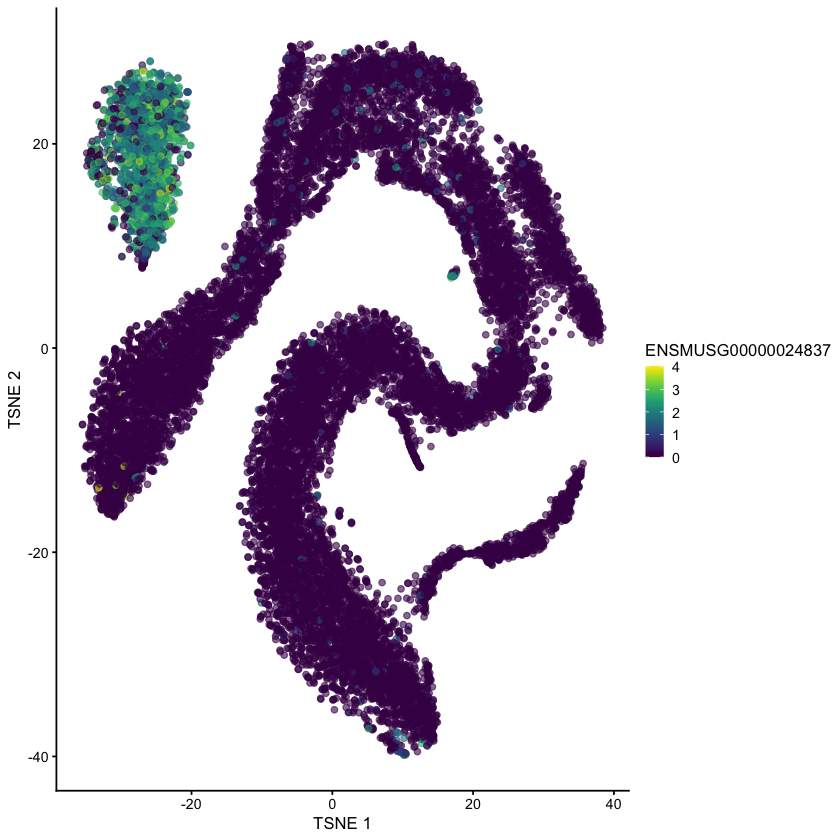

In [63]:
# Visualise gene expression of Dmrt1 in the TSNE plot
geneSymbol = rowData(sce_TF)[ rowData(sce_TF)[,"Symbol"]=="Dmrt1"  ,"ID"] 

plotTSNE(sce_TF, colour_by=geneSymbol )

In [64]:
save(sce_TF, file="data/ernst/spermatogenesisAllCellsErnstTF.Rdata")